In [2]:
%matplotlib notebook
import numpy as np
from PIL import Image

import numpy as np
from numpy.fft import fft2, ifft2, fftshift
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
import scipy
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d as gf1d
from scipy.ndimage import gaussian_filter as gf
from scipy.ndimage import uniform_filter as uf
from skimage.transform import downscale_local_mean #For binning

from statistics import median
from statistics import mode

import xarray as xr #package for labeling and adding metadata to multi-dimensional arrays

import sys
#sys.path.append("../kai_colloids/PyDDM") #must point to the PyDDM folder
#import ddm_analysis_and_fitting as ddm   
3
import tiff_file 

import io 
import sys
import csv

import os
import glob #glob is helpful for searching for filenames or directories
import pickle #for saving data
### usually this block prints out "nd2reader module not found. Reading of .nd2 files disabled." on the first run
### this is fine (unless you need to read .nd2 files), just re-run this block to make the error go away

In [27]:
def floodfill_flat(array, x, y, rows, cols):
    stack = []
    if array[x,y] != -1:
        return 0
    stack.append((x,y))
    currclustersize = 1
    array[x,y] = -2
    while stack:
        xcurr, ycurr = stack.pop()
        if xcurr > 0:
            if array[xcurr-1,ycurr] == -1:
                array[xcurr-1,ycurr] = -2
                currclustersize += 1
                stack.append((xcurr-1,ycurr))
        if xcurr < rows-1:
            if array[xcurr+1,ycurr] == -1:
                array[xcurr+1,ycurr] = -2
                currclustersize += 1
                stack.append((xcurr+1,ycurr))
        if ycurr > 0:
            if array[xcurr,ycurr-1] == -1:
                array[xcurr,ycurr-1] = -2
                currclustersize += 1
                stack.append((xcurr,ycurr-1))
        if ycurr < cols-1:
            if array[xcurr,ycurr+1] == -1:
                array[xcurr,ycurr+1] = -2
                currclustersize += 1
                stack.append((xcurr,ycurr+1))
    return currclustersize


def markcluster_flat(array, x, y, rows, cols, clustersize):
    stack = []
    if array[x,y] != -2:
        return
    stack.append((x,y))
    array[x,y] = clustersize
    while stack:
        xcurr, ycurr = stack.pop()
        if xcurr > 0:
            if array[xcurr-1,ycurr] == -2:
                array[xcurr-1,ycurr] = clustersize
                stack.append((xcurr-1,ycurr))
        if xcurr < rows-1:
            if array[xcurr+1,ycurr] == -2:
                array[xcurr+1,ycurr] = clustersize
                stack.append((xcurr+1,ycurr))
        if ycurr > 0:
            if array[xcurr,ycurr-1] == -2:
                array[xcurr,ycurr-1] = clustersize
                stack.append((xcurr,ycurr-1))
        if ycurr < cols-1:
            if array[xcurr,ycurr+1] == -2:
                array[xcurr,ycurr+1] = clustersize
                stack.append((xcurr,ycurr+1))
                
def rows_n_cols(im):
    imarray = np.array(im)
    rows, cols = np.shape(imarray)
    return rows, cols

### filtimage removes the background 
def filtimage(image, filtersize=600):
    image = (image/100)**1.6 #(array)^1.6 to increase contrast (i think this works?)
    image = (image*10) +1000
    image = (image*1.0) - ((uf(image,filtersize))*1)  #(image) - unifrom-filtered(image) subtracts background
    image = image + 1500  #return pixel array values back to their original range 
    return image

def threshold_images(fsize, im, i, return_marked, filt):
    if filt == False:
        im = im
    else:
        im = filtimage(im, filtersize= fsize)
    imarray = np.array(im)
    rows, cols = np.shape(imarray)
    sys.setrecursionlimit(rows*cols)
    med = np.median(imarray)
    if frame_key == 2:
        if i == 5:
            imarray = imarray + 20
        if i == 6:
            imarray = imarray + 60
        if i == 7:
            imarray = imarray + 105
        if i > 7:
            imarray = imarray + 125
    thresh = 1.09*med #1.12*med  #1.8*med
    arraythresh = (imarray) > thresh
    threshimage = Image.fromarray(arraythresh)
### mark unclustered pixels with -1
    marked_arraythresh = -1*(imarray > thresh)
    if return_marked == False:
        return threshimage
    if return_marked == True:
        return marked_arraythresh
    #return marked_arraythresh, threshimage

def show_filtered_images(fsize, row, ax, i, frame_key, filt):
    index_add = arr_length * (row -1)
    raw_image = tiff_file.imread(files[i+index_add],key=[frame_key])
    #print(files[i+index_add])
    if time_array[i] == 0:
        empty_im = np.zeros((1440,1920))
        ax.imshow(empty_im, cmap = 'gray')
        ax.set_title('[no image]', fontsize=10)
    elif filt == False:
        ax.imshow(raw_image, cmap = 'gray')
        ax.set_title("~" + str(time_array[i]) + " hrs (row"+str(row)+", fsize=none)", fontsize=10)
    else:
        filtered_image = filtimage(raw_image, filtersize= fsize)
        ax.imshow(filtered_image, cmap = 'gray')
        ax.set_title("~" + str(time_array[i]) + " hrs (row"+str(row)+", fsize="+str(fsize)+")", fontsize=10)
    ax.axis('off')
    plt.tight_layout(pad=.2)
    
    
def show_threshold_images(fsize, row, ax, i, frame_key, filt):
    index_add = arr_length * (row -1)
    return_marked = False
    if time_array[i] == 0:
        threshold_image = np.zeros((1440,1920))
        ax.set_title('[no image]', fontsize=10)
    else:
        raw_image = tiff_file.imread(files[i+index_add],key=[frame_key])
        ax.set_title("~" + str(time_array[i]) + " hrs (row"+str(row)+") --> threshold", fontsize=10)
        threshold_image = threshold_images(fsize, raw_image, i, return_marked, filt)
    ax.imshow(threshold_image, cmap = 'gray')
    ax.axis('off')
    plt.tight_layout(pad=.2)
    
def cluster_analysis(i, row_num, arraythresh, rows, cols):
    #print('working...')
    clusters = []
    for x in range(rows):
        #if x % 25 == 0:  #progress update
        #    print(100*x/rows)
        for y in range(cols):
            if arraythresh[x,y] == -1:
                #fill in this cluster
                clustersize = floodfill_flat(arraythresh, x, y, rows, cols)
                clusters.append(clustersize)
                #print(clustersize,x,y)
                #mark finished cluster with size
                markcluster_flat(arraythresh,x,y,rows,cols,clustersize)

    max_size = (max(clusters)) * (pixel_size**2)  #pixel size squared b/c max size is an area
    mean_size = (sum(clusters) / len(clusters)) * (pixel_size**2)  #pixel size squared b/c max size is an area
    median_size = (median(clusters)) * (pixel_size**2)
    mode_size = (mode(clusters)) * (pixel_size**2)
    
    print("for row"+str(row_num)+", t= "+str(time_array[i]) + " hrs:")
    print('   max size: %5.3f, mean size: %5.3f, median: %5.3f, mode: %5.3f' %(max_size, mean_size, median_size, mode_size))
    
    return max_size, mean_size, median_size, mode_size

In [5]:
directory = "Z"
exp = "10-15-22_s1_theBigOne2"
### "data_dir" is the pathway to the folder holding the tiff files to be analyzed 
data_dir = directory+":\\Gregor L\\__Kai Colloids\\"+exp+"\\all tiff files\\"
### "plot_saveto" is the pathway to the folder where plots and results will be saved
saveto_dir = directory+":\\Gregor L\\__Kai Colloids\\"+exp+"\\threshold results\\"

files = glob.glob(data_dir+"*_t*") ### this should generate an ordered list of files in "data_dir" which have "_t" in their name
print("found %i files" % len(files))
for i,f in enumerate(files): print (' %i \t %s' % (i, f.split('\\')[-1]))

found 54 files
 0 	 row1_t1.tif
 1 	 row1_t2.tif
 2 	 row1_t3.tif
 3 	 row1_t4.tif
 4 	 row1_t5.tif
 5 	 row1_t6.tif
 6 	 row1_t7.tif
 7 	 row1_t8.tif
 8 	 row1_t9.tif
 9 	 row2_t1.tif
 10 	 row2_t2.tif
 11 	 row2_t3.tif
 12 	 row2_t4.tif
 13 	 row2_t5.tif
 14 	 row2_t6.tif
 15 	 row2_t7.tif
 16 	 row2_t8.tif
 17 	 row2_t9.tif
 18 	 row3_t1.tif
 19 	 row3_t2.tif
 20 	 row3_t3.tif
 21 	 row3_t4.tif
 22 	 row3_t5.tif
 23 	 row3_t6.tif
 24 	 row3_t7.tif
 25 	 row3_t8.tif
 26 	 row3_t9.tif
 27 	 row4_t1.tif
 28 	 row4_t2.tif
 29 	 row4_t3.tif
 30 	 row4_t4.tif
 31 	 row4_t5.tif
 32 	 row4_t6.tif
 33 	 row4_t7.tif
 34 	 row4_t8.tif
 35 	 row4_t9.tif
 36 	 row5_t1.tif
 37 	 row5_t2.tif
 38 	 row5_t3.tif
 39 	 row5_t4.tif
 40 	 row5_t5.tif
 41 	 row5_t6.tif
 42 	 row5_t7.tif
 43 	 row5_t8.tif
 44 	 row5_t9.tif
 45 	 row6_t1.tif
 46 	 row6_t2.tif
 47 	 row6_t3.tif
 48 	 row6_t4.tif
 49 	 row6_t5.tif
 50 	 row6_t6.tif
 51 	 row6_t7.tif
 52 	 row6_t8.tif
 53 	 row6_t9.tif


In [24]:
frame_names = ["1-3 kA-WT", "WT (no kA)", "EA KaiC", "AE KaiC"]
### array containing the name for each frame in a tiff file to be run 
### e.g. frame 1 is an image of the "50% bKaiB" condition, frame 2 is an image of the "35% bKaiB" condition, etc.

time_array = [1.1, 4.0, 7.4, 10.3, 14.7, 17.7, 20.3, 23.8, 27.0]
#s1 [0.7, 3.7, 6.7, 10.0, 12.8, 17.7, 21.7, 24.9, 28.2]
#s2 [1.0, 3.8, 6.8, 10.2, 13.1, 18.0, 21.9, 25.3, 28.7]
#s1 [1.1, 4.0, 7.4, 10.3, 14.7, 17.7, 20.3, 23.8, 27.0]
#s2 [1.2, 4.4, 7.8, 10.8, 15.2, 18.3, 20.8, 24.3, 28.0]
### array containing the time points corresponding to consecutive tiff files
### e.g. tiff files "bottom_row_t1", "middle_row_t1", and "top_row_t1" all correspond to t = 0.5 hrs, time_array[0]

pixel_size = 0.091 
### pixel size (microns per pixel) of frames/ images in the tiff files --- 40x olympus objective => 0.091 um/px
### IF 2x2 BINNING: multiply the original pixel size by 2^2 = 4, e.g. 4*(0.091 um/px) = 0.364 um/px

eg_im= tiff_file.imread(files[0])
print("tiff file dimensions: "+ str(eg_im.shape))

arr_length = int((len(files))/6)
print("total number of time points: "+ str(arr_length))
if arr_length % 2 == 0:
    num_rows = int(arr_length/2)
else:
    num_rows = int((arr_length+1)/2)
print("(for image previews) number of rows = " + str(num_rows))

font_size = 16  ### font size
dpi_num = 600  ### image quality level (recommendation: 600)

tiff file dimensions: (5, 1440, 1920)
total number of time points: 9
(for image previews) number of rows = 5


# For better results, we filter & 'skeletonize' the images before analysis 
### Do we need to filter out background noise from the images? If so, we can try out different filter sizes to see which works best. The following block previews the images intended for SIA analysis, showing the filtered and skeletonized images
'skeletonize' means we find a specific threshold (based on median intensity), so all pixel values above that threshold = 1, and all pixel values below that threshold = 0. This gives structures clean borders for improved correlation analysis, g(r).

condition: 1-3 kA-WT


<IPython.core.display.Javascript object>


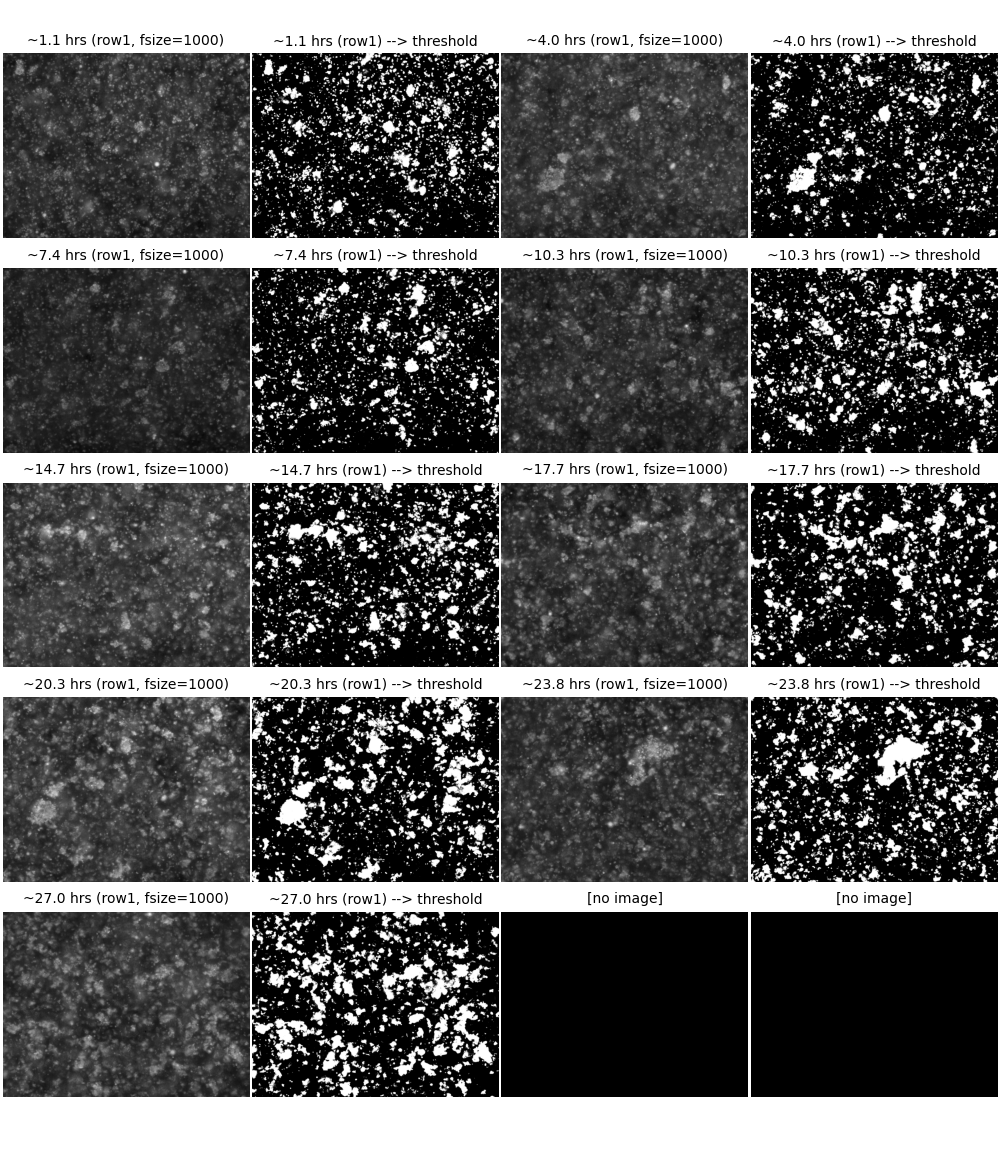

[1.1, 4.0, 7.4, 10.3, 14.7, 17.7, 20.3, 23.8, 27.0]


In [28]:
frame_key = 0
### "frame_key" specifies which frame of each tiff file will be analyzed (each frame of my tiff is for a different condition)
### e.g. "key = 0" dictates that the first frame of each tiff file should be analyzed
condition = frame_names[frame_key]
print("condition: "+condition)

fsize = 1000
filt = True
### set filter size (pixel area used to estimate and remove average background pixel intensities, recommendation = 600
if filt == False:
    f = "none" 
else:
    f = str(fsize)

row = 1
### choose which set of tiff files should be analyzed, row1, row2 or row3

fig_height = num_rows*2.3
time_array.append(0)
i = 0
fig, axs = plt.subplots(num_rows, 4, figsize=(10,fig_height))
for j, ax in enumerate(axs.flatten()):
    if j % 2 == 0:
        show_filtered_images(fsize, row, ax, i, frame_key, filt)
    else:
        show_threshold_images(fsize, row, ax, i, frame_key, filt)
        i = i + 1 
plt.show()
time_array.remove(0)
print(time_array)

### option to save this figure (uncomment below)
fig.savefig(saveto_dir+"threshold vs filtered images for "+condition+" (row"+str(row)+", f="+f+")"+".jpg", dpi=dpi_num)

In [19]:
row1_thresh = [0.0] * int(arr_length)
row2_thresh = [0.0] * int(arr_length)
row3_thresh = [0.0] * int(arr_length)

row1_results = [0.0] * int(arr_length)
row2_results = [0.0] * int(arr_length)
row3_results = [0.0] * int(arr_length)

[1.1, 4.0, 7.4, 10.3, 14.7, 17.7, 20.3, 23.8, 27.0]


In [76]:
#frame_key = 0
cmap = matplotlib.cm.get_cmap('Greys')

i_num = arr_length+1

if i_num == arr_length+1:
    stop_filter_index =  'filtered all images'
elif no_filter_i == 0:
    stop_filter_index_ =  'all images unfiltered'
else:
    stop_filter_index = 'filtered up to '+ str(time_array[i_num-1]) + ' hrs'

for i in range(arr_length):    
    frame_num = "frame %i" % int(frame_key +1)    ### used in plot title to specify which frame of all tiff files was analyzed
    data_file = str(time_array[i]) + " hrs" ### used in legend to show time points corresponding to each curve
    
### 
    row1_thresh[i] = threshold_images(tiff_file.imread(files[i], key=[frame_key]), i_num, i, 
                                      return_marked = True)
    row2_thresh[i] = threshold_images(tiff_file.imread(files[i + arr_length], key=[frame_key]), i_num, i, 
                                      return_marked = True)
    row3_thresh[i] = threshold_images(tiff_file.imread(files[i + (arr_length*2)], key=[frame_key]), i_num, i, 
                                      return_marked = True)
    rows, cols, = rows_n_cols(tiff_file.imread(files[0], key=[frame_key]))
    
    r1_num_clusters, r1_max_size, r1_mean_size, r1_avg_pixel_clustering = cluster_analysis(i, 1, row1_thresh[i], rows, cols)
    r2_num_clusters, r2_max_size, r2_mean_size, r2_avg_pixel_clustering = cluster_analysis(i, 2, row2_thresh[i], rows, cols)
    r3_num_clusters, r3_max_size, r3_mean_size, r3_avg_pixel_clustering = cluster_analysis(i, 3, row3_thresh[i], rows, cols)
    
    row1_results[i] = (r1_num_clusters, r1_max_size, r1_mean_size, r1_avg_pixel_clustering)
    row2_results[i] = (r2_num_clusters, r2_max_size, r2_mean_size, r2_avg_pixel_clustering)
    row3_results[i] = (r3_num_clusters, r3_max_size, r3_mean_size, r3_avg_pixel_clustering)

for row1, t= 0.5 hrs:
   clusters detected: 6585.000, max cluster size: 559.195, mean cluster size: 2.958
for row2, t= 0.5 hrs:
   clusters detected: 8540.000, max cluster size: 259.168, mean cluster size: 2.965
for row3, t= 0.5 hrs:
   clusters detected: 10243.000, max cluster size: 394.576, mean cluster size: 2.793
for row1, t= 3.2 hrs:
   clusters detected: 8341.000, max cluster size: 410.592, mean cluster size: 3.386
for row2, t= 3.2 hrs:
   clusters detected: 9511.000, max cluster size: 321.048, mean cluster size: 3.050
for row3, t= 3.2 hrs:
   clusters detected: 11605.000, max cluster size: 480.844, mean cluster size: 2.744
for row1, t= 17.75 hrs:
   clusters detected: 7122.000, max cluster size: 449.995, mean cluster size: 2.731
for row2, t= 17.75 hrs:
   clusters detected: 9617.000, max cluster size: 500.773, mean cluster size: 2.855
for row3, t= 17.75 hrs:
   clusters detected: 10698.000, max cluster size: 325.234, mean cluster size: 2.341
for row1, t= 20 hrs:
   clusters dete

<ipython-input-13-bdbe055cea4d>:151: RuntimeWarning: overflow encountered in long_scalars
  avg_pixel_clustering = sum(sum(arraythresh)) / sum(sum(arraythresh > 0))


for row3, t= 40.5 hrs:
   clusters detected: 8163.000, max cluster size: 2379.468, mean cluster size: 5.784
for row1, t= 44 hrs:
   clusters detected: 7000.000, max cluster size: 409.864, mean cluster size: 4.447
for row2, t= 44 hrs:
   clusters detected: 7881.000, max cluster size: 1422.694, mean cluster size: 4.954
for row3, t= 44 hrs:
   clusters detected: 7143.000, max cluster size: 3974.425, mean cluster size: 8.752


[2.90521736 3.06014659 2.64209058 2.90938659 3.01451839 2.9502593
 3.13559314 4.60243062 6.05088588]
[0.04599876 0.15139096 0.12658314 0.03419764 0.15932233 0.16030557
 0.10752626 0.48489248 1.10918719]


<IPython.core.display.Javascript object>


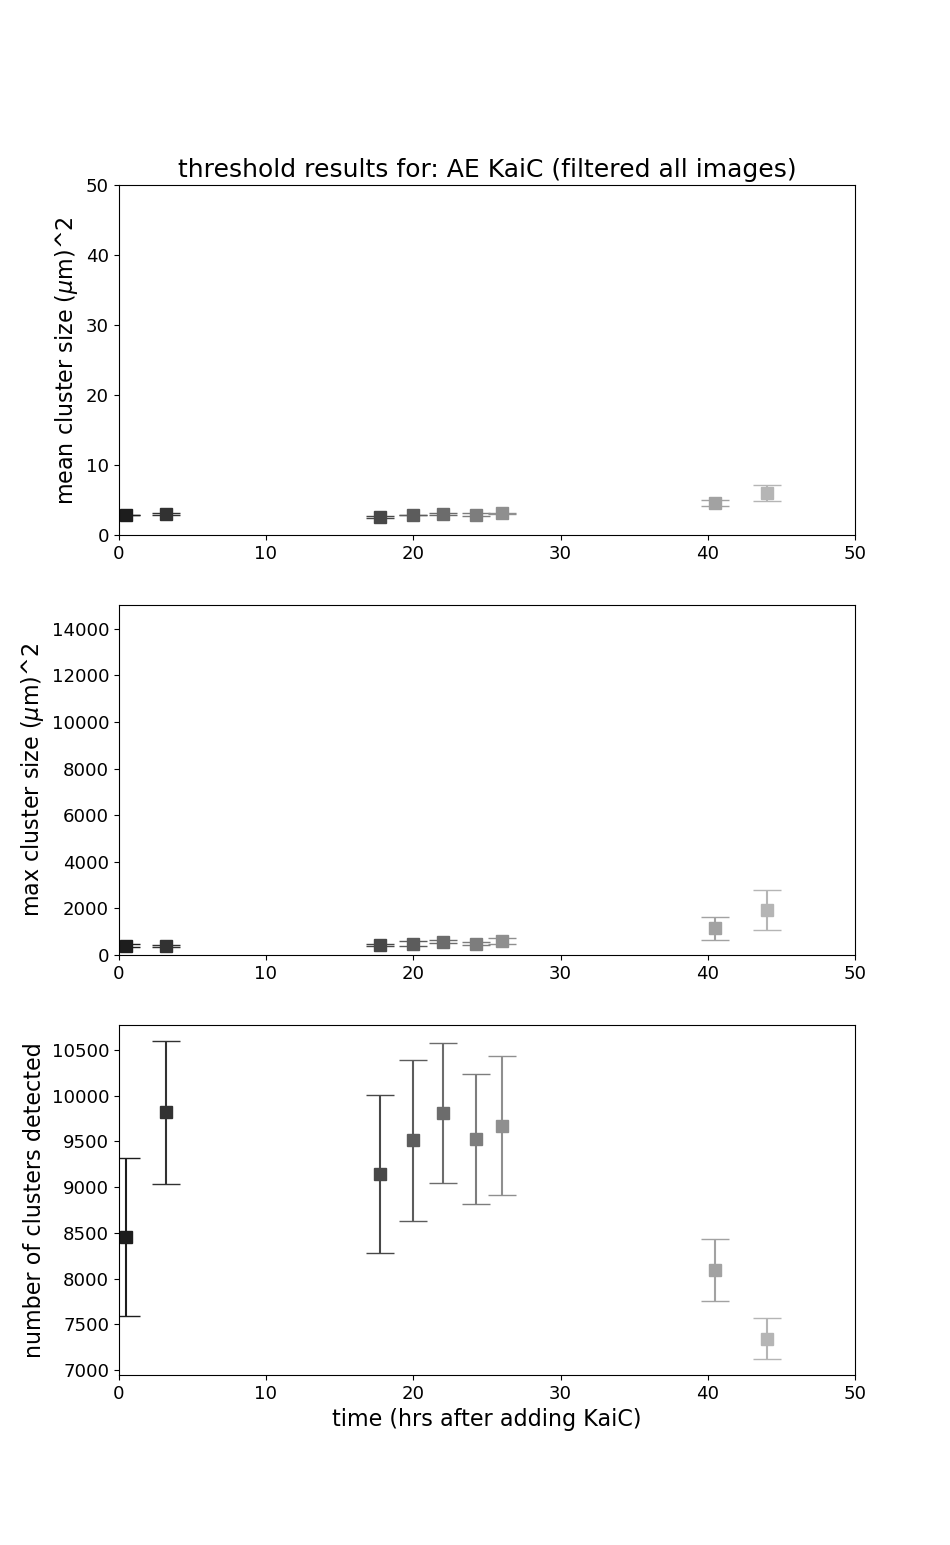

In [77]:
cmap_num = (arr_length*2) - 2
fig_size = 9.5,25/1.618
condition = frame_names[frame_key]

### set up empty arrays
all_mean_size = np.zeros((3,len(row1_results)))
avg_mean_size = np.empty(len(row1_results))
stderror_mean_size = np.empty(len(row1_results))

### find average values and std. error
for i in range(len(row1_results)):
    all_mean_size[0,i] = row1_results[i][2]
    all_mean_size[1,i] = row2_results[i][2]
    all_mean_size[2,i] = row3_results[i][2]
    #print(all_L1.mean(axis=0))
avg_mean_size = all_mean_size.mean(axis=0)
stderror_mean_size = all_mean_size.std(axis=0)/np.sqrt(3)
print(avg_mean_size)
print(stderror_mean_size)

### set up empty arrays
all_max_size = np.zeros((3,len(row1_results)))
avg_max_size = np.empty(len(row1_results))
stderror_max_size = np.empty(len(row1_results))

### find average values and std. error 
for i in range(len(row1_results)):
    all_max_size[0,i] = row1_results[i][1]
    all_max_size[1,i] = row2_results[i][1]
    all_max_size[2,i] = row3_results[i][1]
    #print(all_L1.mean(axis=0))
avg_max_size = all_max_size.mean(axis=0)
stderror_max_size = all_max_size.std(axis=0)/np.sqrt(3)

### set up empty arrays
all_cnums = np.zeros((3,len(row1_results)))
avg_cnums = np.empty(len(row1_results))
stderror_cnums = np.empty(len(row1_results))

### find average values and std. error 
for i in range(len(row1_results)):
    all_cnums[0,i] = row1_results[i][0]
    all_cnums[1,i] = row2_results[i][0]
    all_cnums[2,i] = row3_results[i][0]
    #print(all_L1.mean(axis=0))
avg_cnums = all_cnums.mean(axis=0)
stderror_cnums = all_cnums.std(axis=0)/np.sqrt(3)

### plot average values and std. error for L1 correlation lengths
fig = plt.figure(figsize=(fig_size))
gs = fig.add_gridspec(3, hspace=0.2)
axs = gs.subplots(sharex=False, sharey=False)
#fig, axs = plt.subplots(3, figsize=(fig_size))
markerSize = 8
title = "threshold results for: " + condition +" ("+ stop_filter_index+")"

for i in range(int(len(time_array))):
    axs[0].set_title(title, fontsize= (font_size+2))
    axs[0].set( ylabel='mean cluster size ($\mu$m)^2')
    axs[0].set_ylim(0, 50)
    axs[0].plot(time_array[i], avg_mean_size[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)), label = "mean cluster size")
    axs[0].errorbar(time_array[i], avg_mean_size[i], yerr = stderror_mean_size[i], fmt = 'none', 
                ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
    
    axs[1].set( ylabel='max cluster size ($\mu$m)^2')
    axs[1].set_ylim(0, 15000)
    axs[1].plot(time_array[i], avg_max_size[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)), label = "max cluster size")
    axs[1].errorbar(time_array[i], avg_max_size[i], yerr = stderror_max_size[i], fmt = 'none', 
                ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
    
    axs[2].set(xlabel='time (hrs after adding KaiC)', ylabel='number of clusters detected')
    axs[2].plot(time_array[i], avg_cnums[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)), label = "mean cluster size")
    axs[2].errorbar(time_array[i], avg_cnums[i], yerr = stderror_cnums[i], fmt = 'none', 
                ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
for ax in axs.flat:
    ax.set_xlim(0, 50)
    ax.tick_params(axis='both', which='major', labelsize=(font_size-3))
    #ax.tight_layout(pad=.2)
    ax.xaxis.get_label().set_fontsize(font_size)
    ax.yaxis.get_label().set_fontsize(font_size)
    
#ax.legend()
#plt.ylim(0,13)

#plt.title(title_plus, fontsize=font_size -4)
plt.show()
fig.savefig(saveto_dir+"threshold results for "+condition+" ("+ stop_filter_index+")"+".jpg", dpi=800)

In [78]:
csv_data_file = exp+" --threshold results"+" ("+ stop_filter_index+")"+".csv"
data_file_exists = os.path.isfile(saveto_dir+csv_data_file)
if data_file_exists:
    print("Data file already exists.")
    with open(saveto_dir + csv_data_file,'a', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow([condition, '', stop_filter_index])
        writer.writerow(['',
                         'clusters detected','','','','','',
                         'max cluster size','','','','','',
                         'mean cluster size','','','','','',
                         'avg clustering of a pixel',''])
        writer.writerow(['time (hrs)',
                         'row1','row2','row3','avg','std error','',
                         'row1','row2','row3','avg','std error','',
                         'row1','row2','row3','avg','std error','',
                         'row1','row2','row3',''])
        for i in range(len(time_array)):
            writer.writerow([time_array[i], 
                             row1_results[i][0], row2_results[i][0], row3_results[i][0], avg_cnums[i], stderror_cnums[i], '',
                             row1_results[i][1], row2_results[i][1], row3_results[i][1], avg_max_size[i], stderror_max_size[i], '',
                             row1_results[i][2], row2_results[i][2], row3_results[i][2], avg_mean_size[i], stderror_mean_size[i], '', 
                             row1_results[i][3], row2_results[i][3], row3_results[i][3], '',])
        writer.writerow([''])
    f.close()
    print("Results appended to file.")
else:
    print("Data file does NOT exist.")
    header = []
    np.savetxt(saveto_dir+csv_data_file, header, fmt="%s", delimiter=',')
    with open(saveto_dir + csv_data_file,'a', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow([condition, '', stop_filter_index])
        writer.writerow(['',
                         'clusters detected','','','','','',
                         'max cluster size','','','','','',
                         'mean cluster size','','','','','',
                         'avg clustering of a pixel',''])
        writer.writerow(['time (hrs)',
                         'row1','row2','row3','avg','std error','',
                         'row1','row2','row3','avg','std error','',
                         'row1','row2','row3','avg','std error','',
                         'row1','row2','row3',''])
        for i in range(len(time_array)):
            writer.writerow([time_array[i], 
                             row1_results[i][0], row2_results[i][0], row3_results[i][0], avg_cnums[i], stderror_cnums[i], '',
                             row1_results[i][1], row2_results[i][1], row3_results[i][1], avg_max_size[i], stderror_max_size[i], '',
                             row1_results[i][2], row2_results[i][2], row3_results[i][2], avg_mean_size[i], stderror_mean_size[i], '', 
                             row1_results[i][3], row2_results[i][3], row3_results[i][3], '',])
        writer.writerow([''])
    f.close()
    print("New csv created, results appended to file.")

Data file already exists.
Results appended to file.


In [79]:
csv_data_file = exp+" --threshold results (for box plots"+", "+ stop_filter_index+")"+".csv"
data_file_exists = os.path.isfile(saveto_dir+csv_data_file)
if data_file_exists:
    print("Data file already exists.")
    with open(saveto_dir + csv_data_file,'a', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow([condition, '', stop_filter_index])
        writer.writerow(['',
                         'clusters detected','','','',
                         'max cluster size','','','',
                         'mean cluster size','','','',
                         'avg clustering of a pixel',''])
        writer.writerow(['time (hrs)',
                         'row1, 2, 3','avg','std error','',
                         'row1, 2, 3','avg','std error','',
                         'row1, 2, 3','avg','std error','',
                         'row1, 2, 3',''])
        for i in range(len(time_array)):
            writer.writerow([time_array[i], 
                             row1_results[i][0], '','','',
                             row1_results[i][1], '','','',
                             row1_results[i][2], '','','',
                             row1_results[i][3], '',])
            writer.writerow([time_array[i], 
                             row2_results[i][0], '','','',
                             row2_results[i][1], '','','',
                             row2_results[i][2], '','','',
                             row2_results[i][3], '',])
            writer.writerow([time_array[i], 
                             row3_results[i][0], avg_cnums[i], stderror_cnums[i], '',
                             row3_results[i][1], avg_max_size[i], stderror_max_size[i], '',
                             row3_results[i][2], avg_mean_size[i], stderror_mean_size[i], '', 
                             row3_results[i][3], '',])
        writer.writerow([''])
    f.close()
    print("Results appended to file.")
else:
    print("Data file does NOT exist.")
    header = []
    np.savetxt(saveto_dir+csv_data_file, header, fmt="%s", delimiter=',')
    with open(saveto_dir + csv_data_file,'a', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow([condition, '', stop_filter_index])
        writer.writerow(['',
                         'clusters detected','','','',
                         'max cluster size','','','',
                         'mean cluster size','','','',
                         'avg clustering of a pixel',''])
        writer.writerow(['time (hrs)',
                         'row1, 2, 3','avg','std error','',
                         'row1, 2, 3','avg','std error','',
                         'row1, 2, 3','avg','std error','',
                         'row1, 2, 3',''])
        for i in range(len(time_array)):
            writer.writerow([time_array[i], 
                             row1_results[i][0], '','','',
                             row1_results[i][1], '','','',
                             row1_results[i][2], '','','',
                             row1_results[i][3], '',])
            writer.writerow([time_array[i], 
                             row2_results[i][0], '','','',
                             row2_results[i][1], '','','',
                             row2_results[i][2], '','','',
                             row2_results[i][3], '',])
            writer.writerow([time_array[i], 
                             row3_results[i][0], avg_cnums[i], stderror_cnums[i], '',
                             row3_results[i][1], avg_max_size[i], stderror_max_size[i], '',
                             row3_results[i][2], avg_mean_size[i], stderror_mean_size[i], '', 
                             row3_results[i][3], '',])
        writer.writerow([''])
    f.close()
    print("New csv created, results appended to file.")

Data file already exists.
Results appended to file.
